In [148]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.optimize import leastsq,curve_fit
import cv2
from scipy import interpolate
from skimage import filters,io
np.set_printoptions(threshold=np.inf)

In [149]:
#读取原图片
def load_image(file_path,file_name,file_ext):
    file = file_path + file_name + file_ext;
    Image = cv2.imread(file,0); #cv加载的图片灰度为0~255
    ret, Binary = cv2.threshold(Image, 0, 255, cv2.THRESH_BINARY)
    [image_y_max,image_x_max] = Binary.shape;
    print(f"原图片高度：{image_y_max},原图片宽度：{image_x_max}");
    
    plt.imshow(Binary,cmap = "gray");
    plt.show();
    for i in range(0,image_x_max):
        for j in range(0,image_y_max):
            if (Image[j,i] != 0):
                Image[j,i] = 1;
    
    return Binary;

In [150]:
#裁剪原图片
def extract_edge(Image,file_path,file_name):
    [image_y_max,image_x_max] = Image.shape;
    min_x = max_x = min_y = max_y = 0;
    sum_col = np.sum(Image,axis=0);
    for i in range(0,image_x_max):
        if (sum_col[i] != 0):
            min_x = i;
            break;
    for i in range(image_x_max-1,min_x,-1):
        if (sum_col[i] != 0):
            max_x = i;
            break;


    sum_row = np.sum(Image,axis=1);
    for i in range(0,image_y_max):   
        if (sum_row[i] != 0):
            min_y = i;
            break; 
    for i in range(image_y_max - 1,min_y,-1):
        if (sum_row[i] != 0):
            max_y = i;
            break;

    Image = Image[min_y:max_y,min_x:max_x];

    [image_y_max, image_x_max] =  Image.shape;
    print('裁剪后高度:%d,裁剪后宽度:%d\n' %(image_y_max,image_x_max));
    
    ## 像素矩阵的值改为0/1。
    for i in range(0,image_x_max):
        for j in range(0,image_y_max):
            if (Image[j,i] != 0):
                Image[j,i] = 1;
                       
                
    plt.xlim((0, image_x_max));
    plt.ylim((image_y_max, 0));
    plt.imshow(Image,cmap = "gray");
    file = file_path + "cut\\" + file_name + "_cut.png";
    plt.savefig(file);
    plt.show();
    return Image;

In [151]:
#采集上下边缘，求中值
def refine(Image):
    [image_y_max, image_x_max] =  Image.shape;
    Image_refine = np.zeros((image_y_max,image_x_max));
    for x in range(0,image_x_max): 
        start = end  = 0;
        for y in range(image_y_max-1,-1,-1):
            v = x;
            u = int(-y + image_y_max - 1);
            if (Image[u,v] != 0):
                if (u == 0) or (Image[u-1,v] == 0):#开始
                    start = u;
                if (u == image_y_max-1) or (Image[u+1,v] == 0):#结束 
                    end = u;
                if(end != 0): # 遍历完一段曲线，求中，把start、end复原
                    mid = int((start+end)/2);
                    Image_refine[mid,v] = 1;
                    start = end  = 0;
            
    plt.imshow(Image_refine,cmap = "gray");
    plt.show();
    return Image_refine;

In [152]:
#调用sobel边缘提取
def sobel(Image):
    x_sobel = cv2.Sobel(Image, cv2.CV_16S, 1, 0)
    y_sobel = cv2.Sobel(Image, cv2.CV_16S, 0, 1)

    absX = cv2.convertScaleAbs(x_sobel) # 转回unit8
    absY = cv2.convertScaleAbs(y_sobel)

    Image_sobel = cv2.addWeighted(absX, 0.5, absY, 0.5, 0);
    
    [image_y_max,image_x_max] = Image_sobel.shape;
    for y in range(image_y_max):
        for x in range(image_x_max):
            if Image_sobel[y,x] != 0:
                Image_sobel[y,x] = 1;
    plt.imshow(Image_sobel,cmap = "gray");
    plt.show();
    return Image_sobel;


In [153]:
def ConnectBreakPoint(Image):
    Neighbors = [(1, 1), (1, -1), (1, 0), (-1, 0), (-1, 1), (-1, -1), (0, 1), (0, -1)];
    [image_y_max,image_x_max] = Image.shape;
    endpoints = [];
    for y in range(1,image_y_max-1):
        for x in range(1,image_x_max-1):
            if Image[y,x] == 1:
                sum_neighbors = 0;
                for neighbor in Neighbors:
                    [dy, dx] = neighbor;
                    sum_neighbors += Image[y+dy,x+dx];
                if sum_neighbors == 3: #是一个端点。
                   print(f"x:{x},y:{y}\n,sum_neighbors:{sum_neighbors}");
                   endpoints.append([y,x]);               
    return endpoints;

原图片高度：1440,原图片宽度：2560


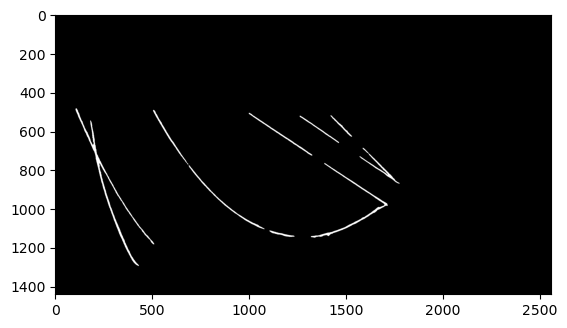

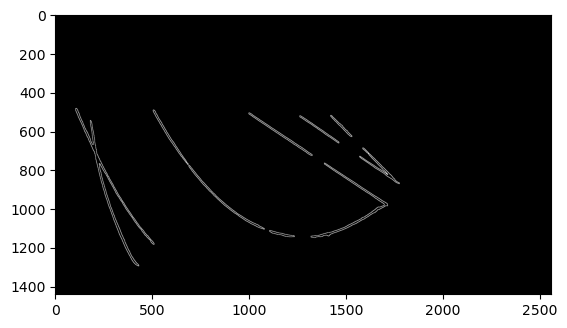

x:113,y:485
,sum_neighbors:3
x:506,y:492
,sum_neighbors:3
x:1421,y:520
,sum_neighbors:3
x:1262,y:522
,sum_neighbors:3
x:1262,y:529
,sum_neighbors:3
x:181,y:546
,sum_neighbors:3
x:1533,y:631
,sum_neighbors:3
x:1587,y:687
,sum_neighbors:3
x:1328,y:728
,sum_neighbors:3
x:1571,y:730
,sum_neighbors:3
x:669,y:750
,sum_neighbors:3
x:1389,y:765
,sum_neighbors:3
x:227,y:768
,sum_neighbors:3
x:688,y:775
,sum_neighbors:3
x:689,y:777
,sum_neighbors:3
x:1778,y:873
,sum_neighbors:3
x:1081,y:1102
,sum_neighbors:3
x:1081,y:1107
,sum_neighbors:3
x:1106,y:1112
,sum_neighbors:3
x:1236,y:1140
,sum_neighbors:3
x:1320,y:1141
,sum_neighbors:3
x:1415,y:1141
,sum_neighbors:3
x:1236,y:1145
,sum_neighbors:3
x:1320,y:1147
,sum_neighbors:3
x:512,y:1185
,sum_neighbors:3
x:433,y:1296
,sum_neighbors:3


In [154]:
file_path = ".\\breakpoint\\"
file_name = ['2 (' + str(f) + ')'  for f in range(1,2)];
file_ext = ".png";

f = '2 (' + str(1) + ')';
file = file_path + f + file_ext;
Image = load_image(file_path,f,file_ext);
#Image_cut = extract_edge(Image,file_path,f);
Image_sobel = sobel(Image);
    #Image_refine = refine(Image_cut);
endpoints = ConnectBreakPoint(Image_sobel);

In [155]:
print(endpoints)

[[485, 113], [492, 506], [520, 1421], [522, 1262], [529, 1262], [546, 181], [631, 1533], [687, 1587], [728, 1328], [730, 1571], [750, 669], [765, 1389], [768, 227], [775, 688], [777, 689], [873, 1778], [1102, 1081], [1107, 1081], [1112, 1106], [1140, 1236], [1141, 1320], [1141, 1415], [1145, 1236], [1147, 1320], [1185, 512], [1296, 433]]


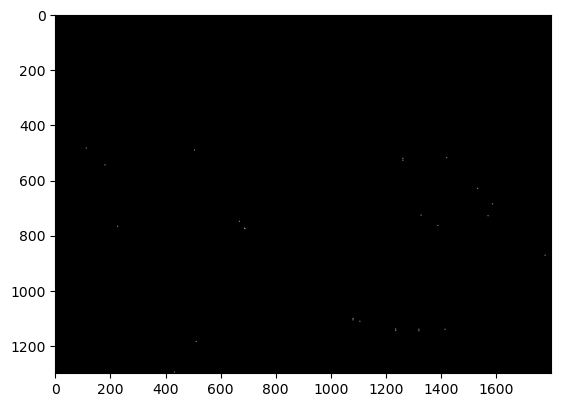

In [156]:
Image = np.zeros((1300,1800))
for point in endpoints:
    [y,x] = point;
    Image[y+1,x+1] = 1;
    Image[y+1,x] = 1;
    Image[y+1,x-1] = 1;
    Image[y,x-1] = 1;
    Image[y,x] = 1;
    Image[y,x+1] = 1;
    Image[y-1,x-1] = 1;
    Image[y-1,x] = 1;
    Image[y-1,x+1] = 1;
plt.imshow(Image,cmap = "gray");
plt.show();